Define a classe correta com base nos parâmetros tipo e categoria presentes em cada questão do dataset Chave

In [1]:
def correct_class(t, c):
    if c == 'COUNT':
        return 'MEASURE'
    if c == 'D' or c == 'DEFINITION':
        return 'DEFINITION'
    if c == 'F' or c == 'FACTOID':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'L' or c == 'LIST':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'LOCATION':
        return 'LOCATION'
    if c == 'MEASURE':
        return 'MEASURE'
    if c == 'OBJECT':
        return 'DEFINITION'
    if c == 'ORGANIZATION':
        return 'ORGANIZATION'
    if c == 'OTHER' and (t == 'FACTOID' or t == 'LIST'):
        return 'OTHER'
    if c == 'OTHER' and not (t == 'FACTOID' or t == 'LIST'):
        return t
    if c == 'PERSON' and t == 'DEFINITION':
        return 'DEFINITION'
    if c == 'PERSON' and not t == 'DEFINITION':
        return 'PERSON'
    if c == 'TIME':
        return 'TIME'
    return c

Realiza o pré-processamento no texto da questão

In [2]:
def pre_processing(text):
    if text is None:
        return None
    ret = text.replace('\n', '').replace('\t', '').replace('\r', '')
    ret = ret.replace('?', '').replace('.', '').replace(',', '')
    ret = ret.replace(':', '').replace(';', '')
    ret = ret.replace('\'', '').replace('\"', '')
    ret = ret.lower()
    ret = ret.replace(u'«', '').replace(u'»', '')
    return ret

Buscar dados do dataset Chave

In [4]:
import xml.etree.ElementTree as et
import qa_system
import re
import numpy as np


path_questions = "data/questions.xml"

X, y = [], []
tree = et.parse(open(path_questions, 'r'))
for question in tree.getroot():
    
    t = question.attrib['tipo']
    c = question.attrib['categoria']
    clss = correct_class(t, c)
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    if clss == 'OTHER':
        continue
    
    for t in question:
        if t.tag == 'texto':
            text = pre_processing(t.text)
            if text is not None:
                text = text.split()
                if type(text) == type(''): text = text.decode('utf-8')
                X.append(text)
                y.append(clss)
                break
        
print 'X:',len(X),' y:',len(y)
X, y = np.array(X), np.array(y)

X: 2973  y: 2973


Modelos de EmbeddingVectorizer

In [5]:
import numpy as np
from collections import Counter, defaultdict


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, LOWER=False):
        self.word2vec = word2vec
        self.word2weight = None
        self.lower = LOWER
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)

def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)

Carregar Modelos

In [6]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec

path_w2v_model = "data/word_embedding/pt.bin"

cbow_w2v_50 = 'data/word_embedding/cbow_s50_w2v.txt'
cbow_w2v_100 = 'data/word_embedding/cbow_s100_w2v.txt'
cbow_w2v_300 = 'data/word_embedding/cbow_s300_w2v.txt'
cbow_w2v_600 = 'data/word_embedding/cbow_s600_w2v.txt'
cbow_w2v_1000 = 'data/word_embedding/cbow_s1000_w2v.txt'

glove_300 = 'data/word_embedding/glove_s300.txt'
cbow_fast_300 = 'data/word_embedding/cbow_s300_fast.txt'

In [7]:
my_model = Word2Vec(X, size=100)
my_w2v = dict(zip(my_model.wv.index2word, my_model.wv.syn0))

Carregar modelos Word2Vec em Português 

In [8]:
word2vec = Word2Vec.load(path_w2v_model)
word2vec.init_sims(replace=True)
w2v = {w: vec for w, vec in zip(word2vec.wv.index2word, word2vec.wv.syn0)}

In [9]:
w2v_50 = KeyedVectors.load_word2vec_format(cbow_w2v_50, unicode_errors="ignore")
w2v_50 = {w: vec for w, vec in zip(w2v_50.index2word, w2v_50.syn0)}

In [10]:
w2v_100 = KeyedVectors.load_word2vec_format(cbow_w2v_100, unicode_errors="ignore")
w2v_100 = {w: vec for w, vec in zip(w2v_100.index2word, w2v_100.syn0)}

In [11]:
w2v_300 = KeyedVectors.load_word2vec_format(cbow_w2v_300, unicode_errors="ignore")
w2v_300 = {w: vec for w, vec in zip(w2v_300.index2word, w2v_300.syn0)}

In [12]:
w2v_600 = KeyedVectors.load_word2vec_format(cbow_w2v_600, unicode_errors="ignore")
w2v_600 = {w: vec for w, vec in zip(w2v_600.index2word, w2v_600.syn0)}

In [ ]:
w2v_1000 = KeyedVectors.load_word2vec_format(cbow_w2v_1000, unicode_errors="ignore")
w2v_1000 = {w: vec for w, vec in zip(w2v_1000.index2word, w2v_1000.syn0)}

In [ ]:
emb_glove_300 = KeyedVectors.load_word2vec_format(glove_300, unicode_errors="ignore")
emb_glove_300 = {w: vec for w, vec in zip(emb_glove_300.index2word, emb_glove_300.syn0)}

In [ ]:
import fasttext
emb_fast_300 = fasttext.load_model(cbow_fast_300)

Definindo os modelos de teste

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC

/home/eduardo/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
all_results = {}
all_models = {}

In [15]:
def test_model(vector_model, classifer, cv=3):
    model = Pipeline([("vector_model", vector_model), ("classifer", classifer)])
    return cross_val_score(model, X, y, cv=cv).mean(), model

Naive Bayes

In [16]:
all_results["NB mult"], all_models["NB mult"] = test_model(count_vectorizer(), MultinomialNB())
all_results["NB mult tfidf"], all_models["NB mult tfidf"] = test_model(tfidf_vectorizer(), MultinomialNB())

In [17]:
all_results["NB bern"], all_models["NB bern"] = test_model(count_vectorizer(), BernoulliNB())
all_results["NB bern tfidf"], all_models["NB bern tfidf"] = test_model(tfidf_vectorizer(), BernoulliNB())

SVM

SVC Linear

In [18]:
all_results["LSVC"], all_models["LSVC"] = test_model(count_vectorizer(), LinearSVC())
all_results["LSVC tfidf"], all_models["LSVC tfidf"] = test_model(tfidf_vectorizer(), LinearSVC())

In [19]:
all_results["LSVC w2v"], all_models["LSVC w2v"] = test_model(MeanEmbeddingVectorizer(w2v), LinearSVC())
all_results["LSVC w2v tfidf"], all_models["LSVC w2v tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v), LinearSVC())

In [20]:
all_results["LSVC w2v50"], all_models["LSVC w2v50"] = test_model(MeanEmbeddingVectorizer(w2v_50), LinearSVC())
all_results["LSVC w2v50 tfidf"], all_models["LSVC w2v50 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_50), LinearSVC())

In [21]:
all_results["LSVC w2v100"], all_models["LSVC w2v100"] = test_model(MeanEmbeddingVectorizer(w2v_100), LinearSVC())
all_results["LSVC w2v100 tfidf"], all_models["LSVC w2v100 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_100), LinearSVC())

In [22]:
all_results["LSVC w2v300"], all_models["LSVC w2v300"] = test_model(MeanEmbeddingVectorizer(w2v_300), LinearSVC())
all_results["LSVC w2v300 tfidf"], all_models["LSVC w2v300 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_300), LinearSVC())

In [23]:
all_results["LSVC w2v600"], all_models["LSVC w2v600"] = test_model(MeanEmbeddingVectorizer(w2v_600), LinearSVC())
all_results["LSVC w2v600 tfidf"], all_models["LSVC w2v600 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_600), LinearSVC())

SVC rbf

In [24]:
all_results["SVC rbf"], all_models["SVC rbf"] = test_model(count_vectorizer(), SVC(kernel="rbf", gamma=0.1))
all_results["SVC rbf tfidf"], all_models["SVC rbf tfidf"] = test_model(tfidf_vectorizer(), SVC(kernel="rbf", gamma=0.1))

SVC poly

In [25]:
all_results["SVC poly"], all_models["SVC poly"] = test_model(count_vectorizer(), SVC(kernel="poly", degree=3, gamma=0.4))
all_results["SVC poly tfidf"], all_models["SVC poly tfidf"] = test_model(tfidf_vectorizer(), SVC(kernel="poly", degree=3, gamma=1))

Obter resultados

model                score
-----------------  -------
LSVC w2v600         0.8742
LSVC tfidf          0.8694
LSVC                0.8667
LSVC w2v            0.8577
LSVC w2v300         0.8570
SVC rbf             0.8422
NB mult             0.8223
SVC poly            0.8180
SVC rbf tfidf       0.8106
LSVC w2v tfidf      0.8042
LSVC w2v100         0.8022
NB mult tfidf       0.7860
LSVC w2v50          0.7271
LSVC w2v600 tfidf   0.7265
SVC poly tfidf      0.7145
LSVC w2v300 tfidf   0.7053
LSVC w2v100 tfidf   0.6989
NB bern             0.6790
NB bern tfidf       0.6790
LSVC w2v50 tfidf    0.6333


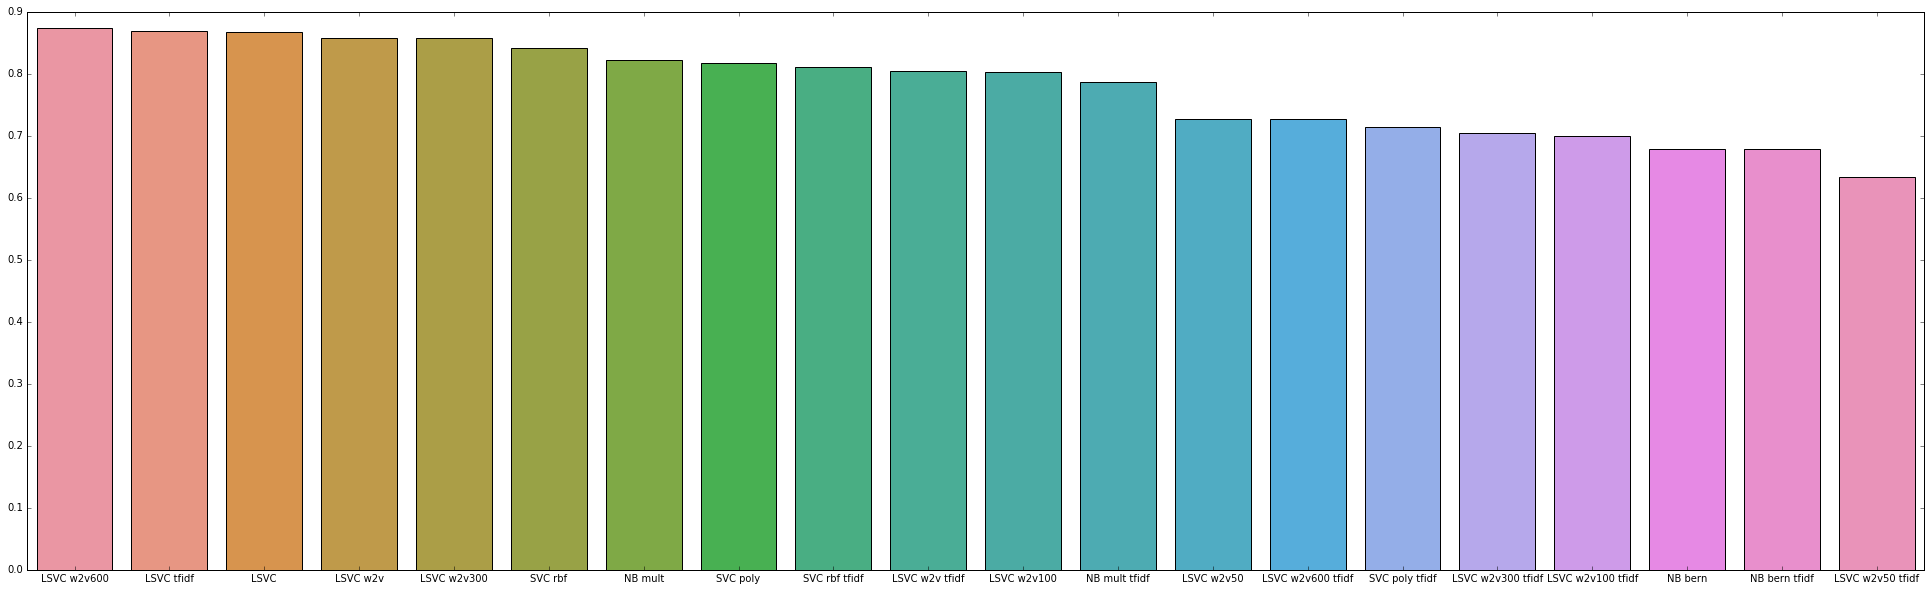

In [26]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

scores = sorted([(result, all_results[result]) 
                 for result in all_results], 
                key=lambda (_, x): -x)

print tabulate(scores, floatfmt=".4f", headers=("model", 'score'))
plt.figure(figsize=(34, 10))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

Realizar testes variando o tamanho do conjunto de treinamento

In [27]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=3, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [34]:
import pandas as pd

train_sizes = [15, 75, 350, 990, 1800, 2967]
table = []
for name in all_models:
    model = all_models[name]
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


Plotar gráfico

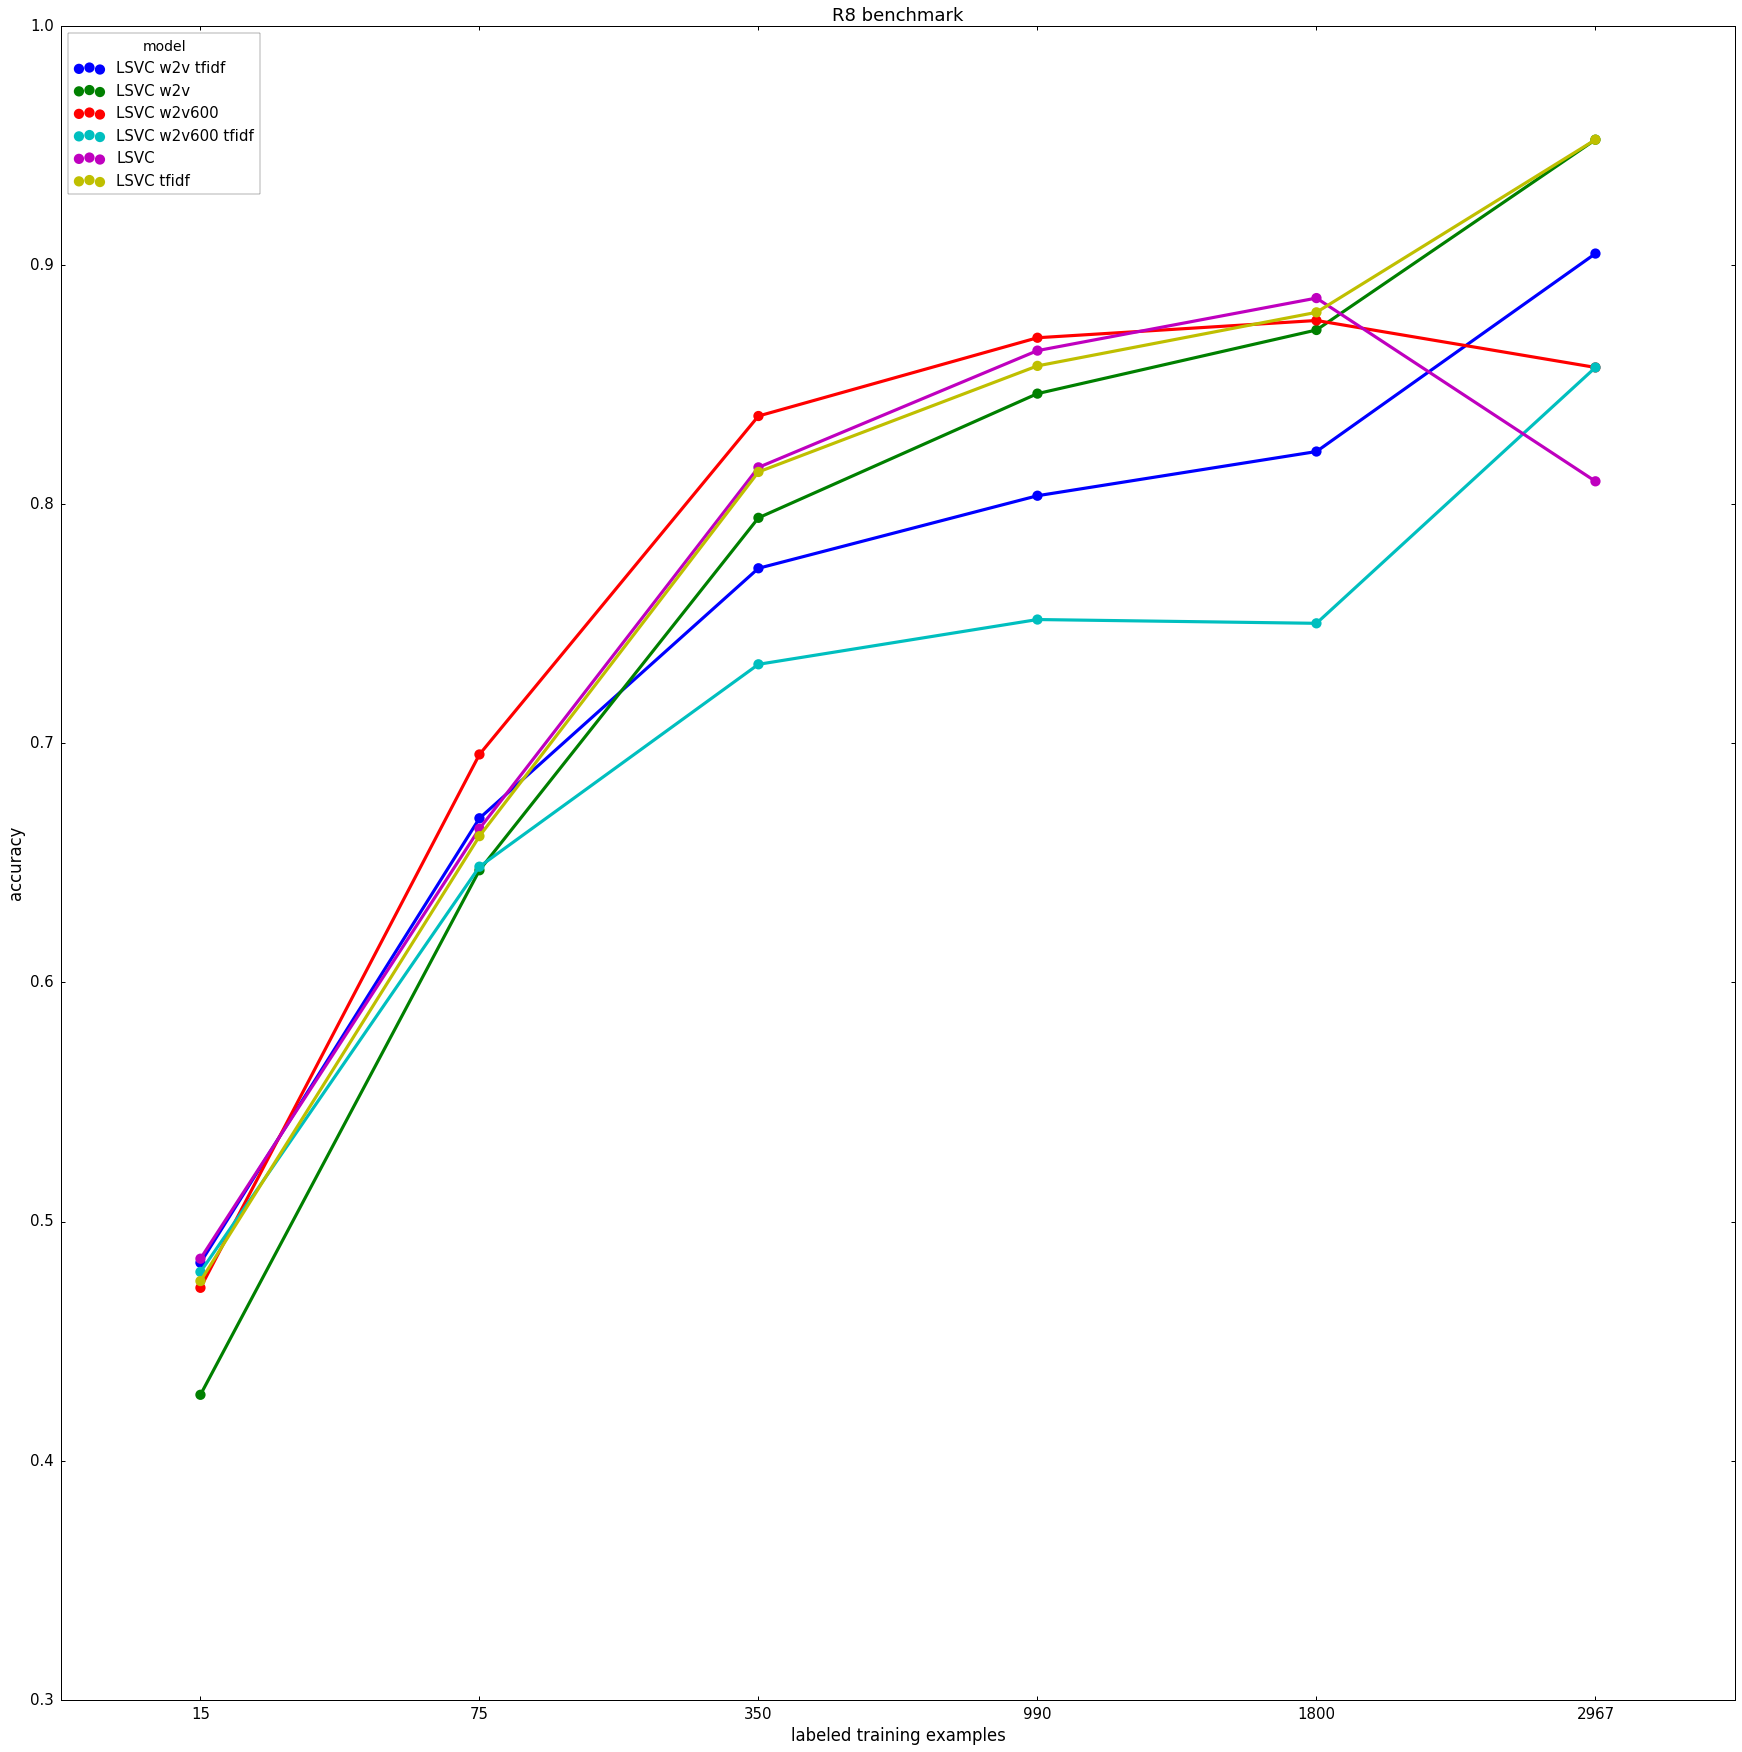

In [35]:
import seaborn as sns
plt.figure(figsize=(30, 30))
names = ['LSVC', 'LSVC tfidf', 'LSVC w2v', 'LSVC w2v tfidf', 'LSVC w2v600', 'LSVC w2v600 tfidf']
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in names)])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")